# Dask DataFrame

Материалы: 
* Макрушин С.В. Лекция 13: Dask DataFrame
* https://docs.dask.org/en/latest/dataframe.html
* JESSE C. DANIEL. Data Science with Python and Dask. 

## Задачи для совместного разбора

1. Считать данные из файлов в каталоге `accounts`. Содержат ли какие-либо из столбцов пропуски?

2. Подсчитать количество раз, которое то или иное имя встретилось в выборке. Вывести самое часто встречающееся имя.

3. Создать новую колонку, которая является результатом от деления значения `amount` нацело на 100, если `amount` > 100, и нулём в противном случае.

## Лабораторная работа 13

In [1]:
import dask.dataframe as dd
import pandas as pd
import dask.bag as db
import json
import dask

1. В архиве `recipes_full.zip` находятся файлы, содержащие информацию об рецептах блюд. Загрузите данные из файлов этого архива в виде `dd.DataFrame` с названием `recipes`. Укажите, что в столбце `submitted` содержатся даты.

In [2]:
recipes = dd.read_csv('recipes_full/recipes_full_*.csv', 
                        parse_dates=['submitted'], 
                        dtype={'minutes': 'float64',
                                'n_steps': 'float64'})
recipes

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
npartitions=8,,,,,,,,
,int64,object,float64,int64,datetime64[ns],float64,object,int64
,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...


2. Выведите метаинформацию о таблице: `npartitions` и типы столбцов.

In [3]:
recipes.npartitions

8

In [4]:
recipes.dtypes

id                         int64
name                      object
minutes                  float64
contributor_id             int64
submitted         datetime64[ns]
n_steps                  float64
description               object
n_ingredients              int64
dtype: object

3. Выведите на экран 5 первых строк таблицы. Выведите на экран 5 последних строк таблицы. В случае сообщения об ошибки объясните причину и исправьте ошибку.

In [5]:
recipes.head(5)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
0,683970,vant ivoire mickies nothing,33.0,803776,2019-08-22,4.0,pat and gina neely and their family own and op...,9
1,1089012,kremsils mariposa baccala cookies class borage...,23.0,51579,2013-03-02,1.0,"a light, tasty and easy to put together chicke...",5
2,1428572,tania lander,0.0,68884,1980-11-09,1.0,a delicious melt in your mouth appetizer. for ...,5
3,1400250,heloise milli asher doogh zojirushi,24.0,678862,2018-04-29,3.0,delicious cream cheese and peach filled cresce...,1
4,387709,nutty chocolate chunk cookies,47.0,489552,2009-08-31,8.0,everyone loves these buttery cookies chock ful...,10


In [6]:
recipes.tail(5)

,id,name,minutes,contributor_id,submitted,n_steps,description,n_ingredients
278949,1029131,tuti waffle snackies steakhouse,19.0,171345,1973-10-18,4.0,"according to a providence journal article, ama...",4
278950,1700703,noelias cheats crocante fleisch zitumbuwa,1.0,30228,2007-07-01,6.0,if possible sauté the onions and garlic in abo...,1
278951,1910650,rubbed restuffed pelmeni bedouin flavourful,60.0,591905,2009-09-26,3.0,another great recipe to add to the growing swe...,2
278952,713836,stems polpettine peezi,NaN,357389,2003-09-30,4.0,adapted from top secret recipes. love this!,9
278953,660699,clementines,64.0,29196,1973-06-03,6.0,this would make a great start to your holiday ...,8


4. Посчитайте, сколько строк содержит каждый из блоков

In [7]:
recipes.map_partitions(len).compute()

0    278955
1    278955
2    278955
3    278955
4    278955
5    278954
6    278954
7    278954
dtype: int64

5. Найдите максимум в столбце `n_steps`. Визуализируйте граф вычислений для этой задачи. Прокомментируйте логику работы `dask` в этом случае.

In [8]:
recipes['n_steps'].max().compute()

145.0

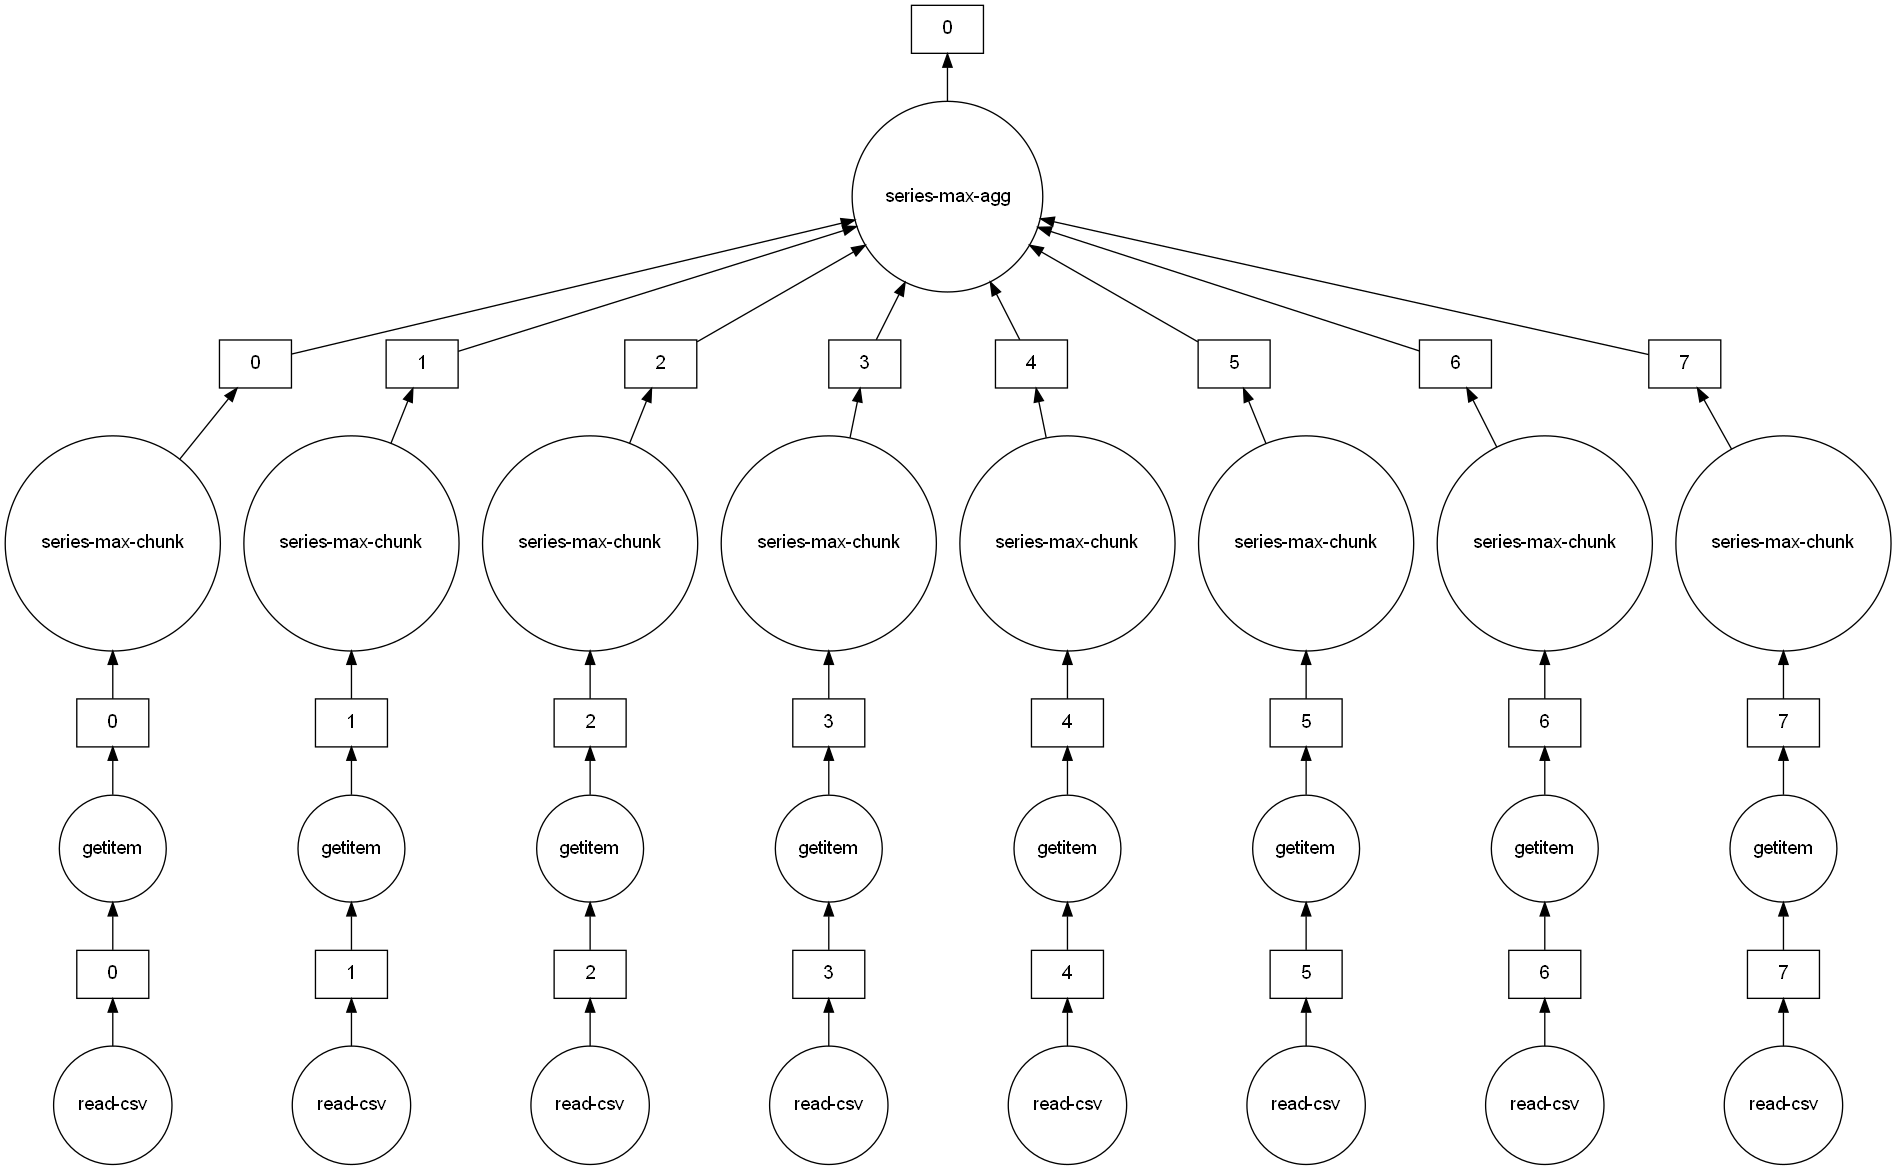

In [9]:
dask.visualize(recipes['n_steps'].max())

6. Посчитайте количество отзывов с группировкой по месяцам добавления отзыва в базу.

In [10]:
recipes_count = recipes.groupby(recipes["submitted"].dt.month).id.count().compute()

In [11]:
recipes_count

submitted
1     193363
2     173834
3     192389
4     186049
5     192487
6     184205
7     189337
8     187276
9     181081
10    187018
11    180974
12    183624
Name: id, dtype: int64

7. Считайте файлы из архива `reviews_full.zip` (__ЛР12__) в виде `dask.bag`. Пользуясь результатом лабораторной работы 12, рассчитайте среднее значение оценок отзывов с группировкой по месяцам. После завершения всех вычислений преобразуйте результат к `pd.Series`.

In [12]:
import re 
import datetime

In [21]:
def parse_json(data):
    jdata = json.loads(data[0])
    ddata = {}
    ddata['rating'] = int(re.findall(r'reviews_(\d).+$', data[1])[0])
    ddata['date'] = datetime.datetime.strptime(jdata['date'], "%Y-%m-%d")
    return ddata
bag = db.read_text('reviews_full/reviews_*.json', include_path=True).map(parse_json)

In [14]:
bdt = bag.to_dataframe()

In [15]:
mean_rating = bdt.groupby(bdt["date"].dt.month).rating.mean().compute()

In [16]:
mean_rating

date
1     4.408553
2     4.407135
3     4.406911
4     4.412259
5     4.415401
6     4.418419
7     4.411717
8     4.410822
9     4.410661
10    4.411452
11    4.408829
12    4.406908
Name: rating, dtype: float64

8. Пользуясь результатами решения задач 6 и 7, создайте `pd.DataFrame`, содержащий два столбца: `mean_rating`, `recipes_count`

In [19]:
df = pd.concat([mean_rating,recipes_count], axis=1)
df.rename(columns={'id': 'recipes_count', 'rating':'mean_rating'}, inplace=True)
df

,mean_rating,recipes_count
1,4.408553,193363
2,4.407135,173834
3,4.406911,192389
4,4.412259,186049
5,4.415401,192487
6,4.418419,184205
7,4.411717,189337
8,4.410822,187276
9,4.410661,181081
10,4.411452,187018
